In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

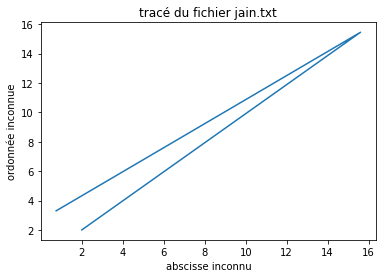

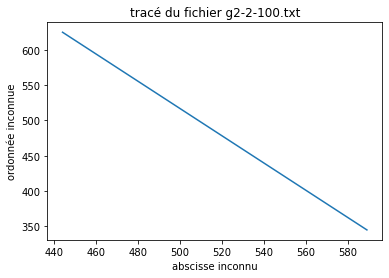

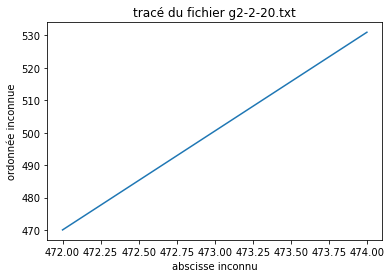

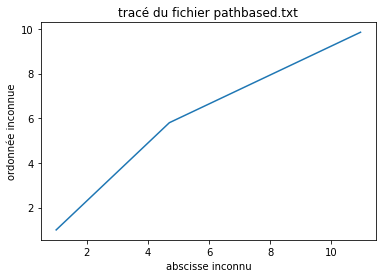

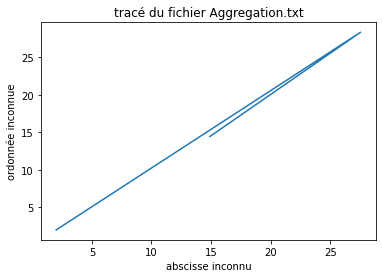

In [4]:
files = ["jain.txt", "g2-2-100.txt", "g2-2-20.txt", "pathbased.txt", "Aggregation.txt"]

for file in files :
    f_in = open("../src/"+file, "r")
    f_out = open("../src/"+file.replace(".txt", "")+"_out.txt", "w")
    for line in f_in :
        f_out.write(re.sub("\s+", ",", line.strip())+"\n")
    f_in.close()
    f_out.close()

for file in files :
    data = pd.read_csv("../src/"+file[:-4]+"_out.txt")
    plt.plot(data.iloc[0], data.iloc[1])
    plt.title("tracé du fichier "+file)
    plt.xlabel("abscisse inconnu")
    plt.ylabel("ordonnée inconnue")
    plt.show()
    a=3
    a = 16165155151



    troi= "toi"
